In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood
from sklearn.model_selection import train_test_split

In [4]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from RotEqNet.layers_2D import *

In [5]:
batch_size = 32
aug = 10
data_path = '../data/'
device = 'cuda'

In [6]:
lrg_data_set   = LRG(112, rd_sz=128, use_kittler=True, n_aug=aug, blur=False, 
                     catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                     file_dir=data_path + 'lrg')

../data/lrg:	1442/1442


In [7]:
x, y = lrg_data_set.get_data()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [8]:
train_dataset = BasicDataset(X_train, y_train, n_aug=10, sz=112) #
test_dataset  = BasicDataset(X_test,  y_test,  n_aug=5,  sz=112)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

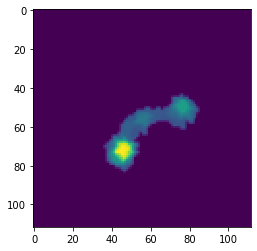

In [9]:
sample = iter(test_dataloader).next()
plt.imshow(sample[0].numpy()[10][0])
plt.show()

In [10]:
def train(model, dataloader, optimizer, epoch, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # backward + optimize
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
        s = 'Train Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\tTrain Acc: {:.4f}'
        s = s.format(epoch,
                100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
        sys.stdout.write('{}\r'.format(s))
        sys.stdout.flush()
    return running_loss, running_corrects, s

In [11]:
def test(model, dataloader, optimizer, epoch, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs

    return running_loss, running_acc#, s

In [12]:
class RotEqDeepClassifier(nn.Module):
    ''' Somewhat inspired in VGG
        Adds option for STN network
    '''
    def __init__(self, nf=None, k=3, num_classes=6, lt_dim=8, batchnorm=True, in_channels=1, non_linearity=nn.ReLU):
        super(RotEqDeepClassifier, self).__init__()
        
        self.non_linearity = non_linearity
                
        if nf == None:
            nf = [32, 'M', 64, 'M', 128, 128, 'M', 'R', 256, 256, 'M']

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(nf[-2] * 7 * 7, lt_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(lt_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        layers = self.__make_layers(nf, batchnorm, k=k)
        self.features = nn.Sequential(*layers)
        self._initialize_weights()

    def __make_layers(self, nf, batch_norm, in_channels=1, mode=1, k=3):
        layers = []
        use_rot = True
        for v in nf:
#             print('=============================',v,'====================')
            if v == 'R':
                use_rot = False
                conv2d = RotConv(in_channels, in_channels, kernel_size=[k, k], padding=k//2, mode=mode, n_angles = 17)
                layers += [conv2d, Vector2Magnitude()]
            elif v == 'M' :
                if use_rot:
                    layers += [VectorMaxPool(kernel_size=2, stride=2)] #keep kernel_size @ 2
                else:
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)] #keep kernel_size @ 2
            else :
                if use_rot:
                    conv2d = RotConv(in_channels, v, kernel_size=[k, k], padding=k//2, mode=mode, n_angles = 17)
                else:
                    conv2d = nn.Conv2d(in_channels, v, kernel_size=k, padding=k//2)
                if batch_norm:
                    if use_rot:
                        layers += [conv2d, VectorBatchNorm(v)]
                    else:
                        layers += [conv2d, nn.BatchNorm2d(v), self.non_linearity(inplace=True)]
                else:
                    if use_rot:
                        layers += [conv2d]
                    else:
                        layers += [conv2d, self.non_linearity(inplace=True)]
                in_channels = v
                mode = 2
        return layers

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        
        y = self.features(x)
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        return y

In [13]:
epochs = 40
lr = 0.0001

In [14]:
model = RotEqDeepClassifier(batchnorm=False, k=9).to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
criterion = nn.CrossEntropyLoss()

In [15]:
torch.cuda.empty_cache()
# def pretty_size(size):
# 	"""Pretty prints a torch.Size object"""
# 	assert(isinstance(size, torch.Size))
# 	return " × ".join(map(str, size))

# def dump_tensors(gpu_only=True):
# 	"""Prints a list of the Tensors being tracked by the garbage collector."""
# 	import gc
# 	total_size = 0
# 	for obj in gc.get_objects():
# 		try:
# 			if torch.is_tensor(obj):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s:%s%s %s" % (type(obj).__name__, 
# 										  " GPU" if obj.is_cuda else "",
# 										  " pinned" if obj.is_pinned else "",
# 										  pretty_size(obj.size())))
# 					total_size += obj.numel()
# 			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
# 				if not gpu_only or obj.is_cuda:
# 					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
# 												   type(obj.data).__name__, 
# 												   " GPU" if obj.is_cuda else "",
# 												   " pinned" if obj.data.is_pinned else "",
# 												   " grad" if obj.requires_grad else "", 
# 												   " volatile" if obj.volatile else "",
# 												   pretty_size(obj.data.size())))
# 					total_size += obj.data.numel()
# 		except Exception as e:
# 			pass        
# 	print("Total size:", total_size)
# dump_tensors()

In [16]:
# o = model.features(sample[0].to(device))

In [17]:
# o[0].shape

In [18]:
# model.half()  # convert to half precision
# for layer in model.modules():
#     if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, VectorBatchNorm):
#         layer.float()

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))
    del train_l, train_c, test_l,  test_c

Train Epoch:   1 (100%)	Loss:	1.2460	rLoss: 15799.97	Train Acc: 0.3511 Test Acc: 0.4258	Time: 659.1836
Train Epoch:   2 (100%)	Loss:	1.1889	rLoss: 13097.16	Train Acc: 0.5087 Test Acc: 0.5797	Time: 661.5944
Train Epoch:   3 (100%)	Loss:	1.2790	rLoss: 12135.39	Train Acc: 0.5331 Test Acc: 0.4665	Time: 662.4409
Train Epoch:   4 (100%)	Loss:	1.4867	rLoss: 11751.61	Train Acc: 0.5563 Test Acc: 0.5178	Time: 662.6539
Train Epoch:   5 (100%)	Loss:	1.5887	rLoss: 12533.54	Train Acc: 0.5450 Test Acc: 0.3992	Time: 662.6925
Train Epoch:   6 (100%)	Loss:	1.8807	rLoss: 12166.78	Train Acc: 0.5421 Test Acc: 0.4547	Time: 662.2765
Train Epoch:   7 (100%)	Loss:	0.9692	rLoss: 11864.79	Train Acc: 0.5587 Test Acc: 0.4288	Time: 662.3713
Train Epoch:   8 (100%)	Loss:	0.7108	rLoss: 11565.65	Train Acc: 0.5742 Test Acc: 0.4462	Time: 662.5547
Train Epoch:   9 (100%)	Loss:	1.0685	rLoss: 11195.90	Train Acc: 0.5860 Test Acc: 0.5322	Time: 662.8033
Train Epoch:  10 (100%)	Loss:	1.2483	rLoss: 11087.29	Train Acc: 0.5914 Te

KeyboardInterrupt: 

In [ ]:
model.features[2:]